# Mummichog tutorial

Here, I describe the steps to run a mummichog analysis within pals

Firstly, import libraries


In [2]:
import os
import sys
import pathlib
import pickle
import random
import matplotlib.pyplot as plt

sys.path.append('../..')

In [3]:
import pandas as pd

In [4]:
from pals.pimp_tools import get_pimp_API_token_from_env, PIMP_HOST, download_from_pimp, get_ms1_peaks
from pals.feature_extraction import DataSource
from pals.PLAGE import PLAGE
from pals.ORA import ORA
from pals.GSEA import GSEA
from pals.common import *
from pals.RunMummichog import *

2021-10-20 20:52:16.904 | WARNING  | pals.reactome:get_neo4j_driver:14 - Using a default neo4j server: bolt://localhost:7687
2021-10-20 20:52:16.908 | WARNING  | pals.reactome:get_neo4j_driver:19 - Using a default neo4j username or password: neo4j
2021-10-20 20:52:16.918 | INFO     | pals.reactome:get_neo4j_driver:24 - Created graph database driver for bolt://localhost:7687 (neo4j)


Following importing libraries, we load peak and annotation data as well as the mass to charge (m/z) 
and retention time data. The m/z data is downloaded directly from PiMP

In [5]:
token = 'e77570ee7f5665c604449ffb4ceba52b06c8603a'
PIMP_API_TOKEN = token

analysis_id = 14 # to find csf study data

In [6]:
ms1_df = get_ms1_peaks(PIMP_API_TOKEN, PIMP_HOST, analysis_id)
ms1_df

2021-10-20 20:52:23.971 | DEBUG    | pals.pimp_tools:get_data:33 - http://polyomics.mvls.gla.ac.uk/export/get_ms1_peaks?analysis_id=14


,pid,sec_id,mass,rt,polarity,cmpd_id,formula,adduct,identified,rc_id,compound,db,identifier,frank_annot,inchikey
0,36739,554,97.991357,1219.664623,positive,1,CaO,M+ACN+H,False,176374,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
1,37132,947,97.991358,1174.563337,positive,1,CaO,M+ACN+H,False,177868,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
2,36808,623,97.991359,1394.926682,positive,1,CaO,M+ACN+H,False,176516,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
3,36723,538,97.991360,1354.241768,positive,1,CaO,M+ACN+H,False,176362,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
4,36883,698,171.005696,1364.849283,positive,2,C5H8O4,M+K,False,176696,Monoethyl malonic acid,hmdb,HMDB00576,NaN,HGINADPHJQTSKN-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6409,37457,1126,168.065645,731.447731,positive,7648,C8H9NO3,M+H,False,179319,Pyridoxal,kegg,C00250,NaN,None
6410,37513,1148,114.055046,437.709974,positive,7649,C5H7NO2,M+H,False,179482,delta-1-Pyrroline-5-carboxylate,kegg,C04322,NaN,None
6411,37788,1278,332.921902,909.031581,negative,7651,C10H14BrCl3O,M-H,False,179895,Costatol,kegg,C17103,NaN,None
6412,38501,1611,332.921899,981.516007,negative,7654,C10H14BrCl3O,M-H,False,181714,Costatol,kegg,C17103,NaN,None


In [8]:
ms1_df.rename(columns={
    'pid': 'row_id',
    'mass': 'm/z',
    'rt': 'retention_time'
}, inplace=True)
ms1_df[['row_id', 'm/z', 'retention_time']].set_index('row_id')
ms1_df.to_csv('mz_df.csv')

ms1_df

,row_id,sec_id,m/z,retention_time,polarity,cmpd_id,formula,adduct,identified,rc_id,compound,db,identifier,frank_annot,inchikey
0,36739,554,97.991357,1219.664623,positive,1,CaO,M+ACN+H,False,176374,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
1,37132,947,97.991358,1174.563337,positive,1,CaO,M+ACN+H,False,177868,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
2,36808,623,97.991359,1394.926682,positive,1,CaO,M+ACN+H,False,176516,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
3,36723,538,97.991360,1354.241768,positive,1,CaO,M+ACN+H,False,176362,Calcium oxide,kegg,C13140,NaN,BRPQOXSCLDDYGP-UHFFFAOYSA-N
4,36883,698,171.005696,1364.849283,positive,2,C5H8O4,M+K,False,176696,Monoethyl malonic acid,hmdb,HMDB00576,NaN,HGINADPHJQTSKN-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6409,37457,1126,168.065645,731.447731,positive,7648,C8H9NO3,M+H,False,179319,Pyridoxal,kegg,C00250,NaN,None
6410,37513,1148,114.055046,437.709974,positive,7649,C5H7NO2,M+H,False,179482,delta-1-Pyrroline-5-carboxylate,kegg,C04322,NaN,None
6411,37788,1278,332.921902,909.031581,negative,7651,C10H14BrCl3O,M-H,False,179895,Costatol,kegg,C17103,NaN,None
6412,38501,1611,332.921899,981.516007,negative,7654,C10H14BrCl3O,M-H,False,181714,Costatol,kegg,C17103,NaN,None


In [9]:
mz_rt_df = ms1_df[['m/z', 'retention_time']]

mz_rt_df

,m/z,retention_time
0,97.991357,1219.664623
1,97.991358,1174.563337
2,97.991359,1394.926682
3,97.991360,1354.241768
4,171.005696,1364.849283
...,...,...
6409,168.065645,731.447731
6410,114.055046,437.709974
6411,332.921902,909.031581
6412,332.921899,981.516007


#Get the rest of the dataframes we need to construct a DataSource object, using PALS function we can get intensity information and annotations directly from PiMP


In [10]:
int_df, annotation_df, experimental_design = download_from_pimp(token, PIMP_HOST, analysis_id, 'kegg')

2021-10-20 20:52:29.675 | DEBUG    | pals.pimp_tools:download_from_pimp:119 - Trying to load data from temp file: C:\Users\simon\AppData\Local\Temp\pimp_analysis_14.p


In [11]:
int_df

,A039P.mzXML,A053P.mzXML,A057P.mzXML,A058P.mzXML,A060P.mzXML,A061P.mzXML,A062P.mzXML,A068P.mzXML,A107P.mzXML,B012P.mzXML,...,A015C.mzXML,A016C.mzXML,A017C.mzXML,A019C.mzXML,A020C.mzXML,B001C.mzXML,B002C.mzXML,A001C.mzXML,A003C.mzXML,A004C.mzXML
row_id,,,,,,,,,,,,,,,,,,,,,
36186,5.660701e+08,5.932865e+08,4.682227e+08,4.422648e+08,5.557492e+08,4.667945e+08,5.573389e+08,3.815666e+08,6.136892e+08,5.415740e+08,...,4.370848e+08,6.121667e+08,5.371572e+08,5.397756e+08,4.515753e+08,5.840201e+08,4.795199e+08,6.127151e+08,5.758748e+08,6.277334e+08
36187,2.584372e+08,2.677779e+08,2.202369e+08,2.286311e+08,2.580824e+08,2.272282e+08,2.663014e+08,2.044546e+08,2.905365e+08,2.505285e+08,...,2.202421e+08,2.751752e+08,2.440404e+08,2.394855e+08,2.256507e+08,2.659387e+08,2.315487e+08,2.726796e+08,2.548970e+08,2.747774e+08
36188,1.364302e+08,1.382290e+08,1.135036e+08,1.120678e+08,1.344521e+08,1.171484e+08,1.376661e+08,9.791551e+07,1.452775e+08,1.267788e+08,...,1.118593e+08,1.391992e+08,1.257877e+08,1.228337e+08,1.086943e+08,1.376156e+08,1.226677e+08,1.420786e+08,1.289906e+08,1.461389e+08
36189,1.167665e+08,1.212871e+08,1.151307e+08,9.691385e+07,1.265301e+08,1.297624e+08,1.190879e+08,9.767463e+07,1.345063e+08,1.171860e+08,...,1.043967e+08,1.240692e+08,1.168321e+08,1.247708e+08,1.036875e+08,1.217804e+08,1.144381e+08,1.259999e+08,1.304112e+08,1.298402e+08
36190,1.770937e+07,1.840550e+07,1.562259e+07,1.637001e+07,1.863920e+07,1.575322e+07,1.942195e+07,1.622399e+07,2.219927e+07,1.891526e+07,...,1.630866e+07,2.025614e+07,1.700938e+07,1.634346e+07,1.604079e+07,1.827413e+07,1.688614e+07,2.016064e+07,1.672281e+07,1.887251e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39727,1.137631e+04,6.098973e+04,3.698302e+04,3.530270e+04,4.475422e+04,4.436386e+04,4.823382e+04,3.288070e+04,5.478839e+04,2.760448e+04,...,3.389645e+04,4.795839e+04,5.367495e+04,4.881163e+04,4.319612e+04,4.886858e+04,5.120511e+04,6.017799e+04,4.254625e+04,5.122880e+04
39728,4.286575e+04,4.714534e+04,4.307921e+04,4.290866e+04,5.046761e+04,5.235502e+04,4.789154e+04,5.079764e+04,5.113102e+04,5.656038e+04,...,4.182031e+04,5.079006e+04,4.172892e+04,6.150502e+04,4.370330e+04,5.073580e+04,5.193784e+04,5.524893e+04,4.142946e+04,4.632614e+04
39729,4.048354e+04,3.888077e+04,4.820593e+04,3.632124e+04,4.319471e+04,4.993739e+04,4.463831e+04,4.138126e+04,4.886430e+04,5.142990e+04,...,3.980221e+04,4.677318e+04,5.097504e+04,5.432266e+04,4.808023e+04,5.208983e+04,5.099948e+04,3.087718e+04,5.282910e+04,3.678989e+04


In [12]:
annotation_df

,entity_id
row_id,
37231,C00111
36883,C00111
36397,C00111
37309,C00111
36199,C00111
...,...
37457,C00250
37513,C04322
37788,C17103


In [13]:
experimental_design

{'comparisons': [{'case': 'Stage_1',
   'control': 'Stage_2',
   'name': 'Stage_1/Stage_2'},
  {'case': 'Stage_2', 'control': 'Control', 'name': 'Stage_2/Control'},
  {'case': 'Stage_1', 'control': 'Control', 'name': 'Stage_1/Control'}],
 'groups': {'Control': ['A020C.mzXML',
   'A014C.mzXML',
   'A009C.mzXML',
   'A011C.mzXML',
   'A003C.mzXML',
   'A015C.mzXML',
   'A016C.mzXML',
   'A004C.mzXML',
   'A001C.mzXML',
   'B001C.mzXML',
   'A008C.mzXML',
   'A010C.mzXML',
   'B002C.mzXML',
   'A005C.mzXML',
   'A019C.mzXML',
   'A017C.mzXML',
   'A013C.mzXML'],
  'Stage_1': ['A019P.mzXML',
   'A053P.mzXML',
   'A010P.mzXML',
   'A011P.mzXML',
   'A039P.mzXML',
   'A107P.mzXML',
   'B016P.mzXML',
   'A021P.mzXML',
   'A013P.mzXML',
   'A057P.mzXML',
   'A024P.mzXML',
   'A068P.mzXML',
   'A060P.mzXML',
   'A012P.mzXML',
   'A008P.mzXML',
   'A058P.mzXML',
   'A062P.mzXML',
   'A061P.mzXML',
   'B012P.mzXML',
   'B014P.mzXML'],
  'Stage_2': ['A023P.mzXML',
   'A044P.mzXML',
   'A027P.mzXML

In [14]:
#sort df by row_id

int_df = int_df.reindex(sorted(int_df.columns), axis=1)
int_df

,A001C.mzXML,A001P.mzXML,A002P.mzXML,A003C.mzXML,A004C.mzXML,A005C.mzXML,A008C.mzXML,A008P.mzXML,A009C.mzXML,A010C.mzXML,...,A081P.mzXML,A082P.mzXML,A083P.mzXML,A107P.mzXML,A118P.mzXML,B001C.mzXML,B002C.mzXML,B012P.mzXML,B014P.mzXML,B016P.mzXML
row_id,,,,,,,,,,,,,,,,,,,,,
36186,6.127151e+08,4.087233e+08,3.565927e+08,5.758748e+08,6.277334e+08,3.997072e+08,6.214990e+08,5.455244e+08,5.228084e+08,5.573633e+08,...,3.491120e+08,4.124747e+08,5.055433e+08,6.136892e+08,4.967120e+08,5.840201e+08,4.795199e+08,5.415740e+08,4.771584e+08,4.667319e+08
36187,2.726796e+08,2.220560e+08,1.879616e+08,2.548970e+08,2.747774e+08,2.045973e+08,2.711476e+08,2.442694e+08,2.463833e+08,2.625147e+08,...,1.867164e+08,2.098798e+08,2.447424e+08,2.905365e+08,2.302146e+08,2.659387e+08,2.315487e+08,2.505285e+08,2.349865e+08,2.317964e+08
36188,1.420786e+08,9.454549e+07,9.779530e+07,1.289906e+08,1.461389e+08,9.901544e+07,1.371838e+08,1.314715e+08,1.251233e+08,1.350838e+08,...,8.872685e+07,1.068299e+08,1.270307e+08,1.452775e+08,1.201612e+08,1.376156e+08,1.226677e+08,1.267788e+08,1.167567e+08,1.200663e+08
36189,1.259999e+08,9.654570e+07,8.381609e+07,1.304112e+08,1.298402e+08,9.358969e+07,1.361706e+08,1.323530e+08,1.184184e+08,1.265139e+08,...,8.037537e+07,9.417155e+07,1.202441e+08,1.345063e+08,1.137046e+08,1.217804e+08,1.144381e+08,1.171860e+08,1.171399e+08,1.078630e+08
36190,2.016064e+07,1.617546e+07,1.397474e+07,1.672281e+07,1.887251e+07,1.451794e+07,1.786245e+07,1.676201e+07,1.718698e+07,1.831481e+07,...,1.448752e+07,1.448341e+07,1.663064e+07,2.219927e+07,1.614626e+07,1.827413e+07,1.688614e+07,1.891526e+07,1.695035e+07,1.583075e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39727,6.017799e+04,3.305169e+04,3.774021e+04,4.254625e+04,5.122880e+04,5.144634e+04,6.651510e+04,3.383649e+04,5.543958e+04,2.775504e+04,...,4.452187e+04,4.139891e+04,3.937648e+04,5.478839e+04,4.103015e+04,4.886858e+04,5.120511e+04,2.760448e+04,4.022374e+04,3.861848e+04
39728,5.524893e+04,4.471079e+04,4.417618e+04,4.142946e+04,4.632614e+04,3.615989e+04,4.392817e+04,4.920196e+04,4.222943e+04,4.898637e+04,...,4.672691e+04,3.589568e+04,3.784676e+04,5.113102e+04,4.134180e+04,5.073580e+04,5.193784e+04,5.656038e+04,3.906630e+04,5.422961e+04
39729,3.087718e+04,3.764938e+04,4.133501e+04,5.282910e+04,3.678989e+04,3.919970e+04,5.085458e+04,5.502905e+04,4.600038e+04,5.198357e+04,...,5.949855e+04,3.238906e+04,3.844145e+04,4.886430e+04,4.276266e+04,5.208983e+04,5.099948e+04,5.142990e+04,5.339018e+04,5.539751e+04


In [15]:
lookup = {}
for group in experimental_design['groups']:
    samples = experimental_design['groups'][group]
    for sample in samples:
        lookup[sample] = group

for sample in int_df.columns:
#     print('%s,%s' % (sample, lookup[sample]))
    print('%s' % (lookup[sample]))

Control
Stage_2
Stage_2
Control
Control
Control
Control
Stage_1
Control
Control
Stage_1
Control
Stage_1
Stage_1
Control
Stage_1
Control
Stage_2
Control
Control
Stage_2
Control
Stage_2
Stage_2
Control
Stage_1
Control
Stage_1
Stage_2
Stage_1
Stage_2
Stage_1
Stage_2
Stage_2
Stage_2
Stage_1
Stage_2
Stage_1
Stage_1
Stage_1
Stage_1
Stage_1
Stage_2
Stage_2
Stage_1
Stage_2
Stage_2
Stage_2
Stage_2
Stage_2
Stage_1
Stage_2
Control
Control
Stage_1
Stage_1
Stage_1


In [16]:
comparisons = [{'case' : 'Stage_1', 'control' : 'Stage_2', 'name' : 'Stage_1/Stage_2'}]

Now we have all the data required to construct a mummichog data source instance

In [18]:
# construct datasource

ds = DataSource(int_df, annotation_df, experimental_design, DATABASE_PIMP_KEGG, mz_rt_df=ms1_df, comparisons=comparisons)

#this ds is sufficient for running ora and plage

2021-10-20 20:52:52.695 | DEBUG    | pals.feature_extraction:__init__:52 - Using PiMP_KEGG as database
2021-10-20 20:52:52.697 | DEBUG    | pals.loader:load_data:42 - Loading C:\Users\simon\PALS\pals\data\PiMP_KEGG.json.zip
2021-10-20 20:52:52.750 | DEBUG    | pals.feature_extraction:__init__:80 - Mapping pathway to unique ids
2021-10-20 20:52:52.764 | DEBUG    | pals.feature_extraction:__init__:94 - Creating dataset to pathway mapping
2021-10-20 20:52:52.921 | DEBUG    | pals.feature_extraction:__init__:122 - Computing unique id counts


In [19]:
#ORA

ora_analysis = ORA(ds)

2021-10-20 20:53:16.326 | DEBUG    | pals.ORA:__init__:21 - ORA initialised


In [20]:
plage_analysis = PLAGE(ds)

2021-10-20 20:53:35.512 | DEBUG    | pals.PLAGE:__init__:31 - PLAGE initialised


To run mummichog, we need to create a new datasource object using the create_mummichog_ds method


In [21]:
mummichog_ds = ds.create_mummichog_ds()

C:\Users\simon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\simon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\simon\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
Read 2316 features as reference list.
Using 606 features (p < 0.050000) as significant list.
Read 2309 features as reference list.
Using 609 features (p < 0.050000) as significant list.


Now we have the datasource for mummichog we can pass it directly to our mummichog pathway analysis classes

In [22]:
mummichog_analysis = MummichogPathwayAnalysis(mummichog_ds)

Got 159 cpd2mzFeatures
Got 202 ListOfEmpiricalCompounds
Got 91 merged ListOfEmpiricalCompounds
Got 40 final ListOfEmpiricalCompounds



Pathway Analysis...


Got 159 cpd2mzFeatures
Got 202 ListOfEmpiricalCompounds
Got 91 merged ListOfEmpiricalCompounds
Got 40 final ListOfEmpiricalCompounds



Pathway Analysis...


In [23]:
results = mummichog_analysis.get_results() #get_results runs the analysis

Query number of significant compounds = 33 compounds
Resampling, 100 permutations to estimate background ...


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


Pathway background is estimated on 11900 random pathway values
Query number of significant compounds = 34 compounds
Resampling, 100 permutations to estimate background ...


 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


Pathway background is estimated on 11900 random pathway values


The analysis runs twice, because we have specified two comparisons in the comparisons variable. get_results() returns a list of pathway analysis objects, so we access each list object to make results graphs and dataframes. The order of results is the same as the order of specified comparisons


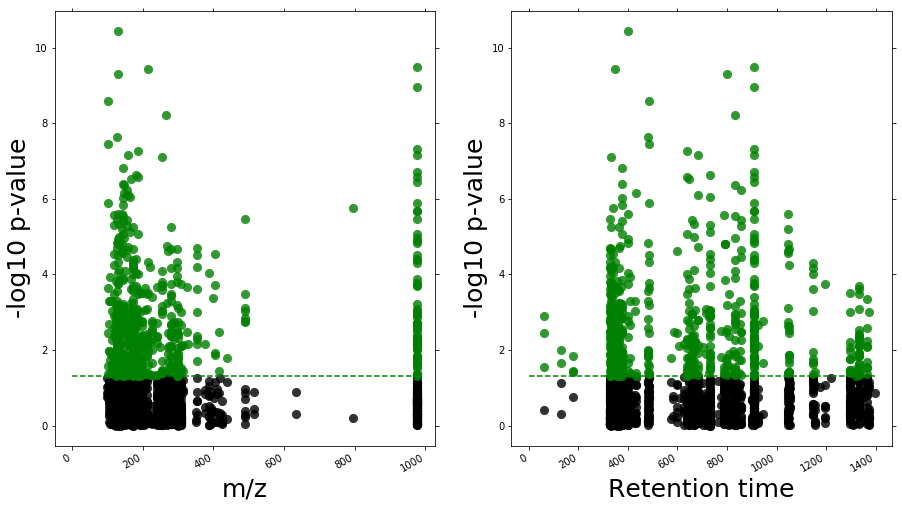

In [33]:
comp1_results = results[0].construct_pathway_enrich_df()
comp1_mwas_plot = results[0].construct_mwas_plots()

In [29]:
comp1_results

,pathway,overlap_size,pathway_size,p-value,overlap_Empirical,overlap_features (id),overlap_features (name)
1,"Glycine, serine, alanine and threonine metabolism",6,6,0.0005041593143433325,"E14,E49,E39,E50,E51,E8","C00065/C00740,C00719/C00431/C00183,C00300,C007...",L-Serine/D-Serine$Glycine betaine/5-Aminopenta...
2,Tyrosine metabolism,6,6,0.0005041593143433325,"E84,E11,E91,E87,E8,E86","C00082/CE2174,C00064/C05100/C00819,C00079/CE21...",L-Tyrosine/$L-Glutamine/3-Ureidoisobutyrate/D-...
3,Glycerophospholipid metabolism,5,5,0.0031089824384505503,"E14,E4,E5,E79,E6","C00065/C00740,C00661/C00111/C00118,C00661/C001...",L-Serine/D-Serine$DL-Glyceraldehyde 3-phosphat...
4,Pyrimidine metabolism,5,5,0.0031089824384505503,"E26,E34,E11,E25,E8","C00906,C01101/C00231/C03736/C00117/C00442/C006...","5,6-Dihydrothymine$L-Ribulose 5-phosphate/D-Xy..."
5,Tryptophan metabolism,4,4,0.00823460213427443,"E83,E32,E8,E7","C00078/C00525,C05648,C00213/C00041/C00099/C001...",L-Tryptophan/D-Tryptophan$5-Hydroxy-N-formylky...
...,...,...,...,...,...,...,...
115,C21-steroid hormone biosynthesis and metabolism,0,0,0.40265523905554157,,,
116,Starch and Sucrose Metabolism,0,0,0.40265523905554157,,,
117,Trihydroxycoprostanoyl-CoA beta-oxidation,0,0,0.40265523905554157,,,
118,Omega-6 fatty acid metabolism,0,0,0.40265523905554157,,,


In [30]:
#subset all pathways over significant level

sig_pathways = comp1_results[comp1_results['p-value'].astype(float) < 0.05]
sig_pathways

,pathway,overlap_size,pathway_size,p-value,overlap_Empirical,overlap_features (id),overlap_features (name)
1,"Glycine, serine, alanine and threonine metabolism",6,6,0.0005041593143433325,"E14,E49,E39,E50,E51,E8","C00065/C00740,C00719/C00431/C00183,C00300,C007...",L-Serine/D-Serine$Glycine betaine/5-Aminopenta...
2,Tyrosine metabolism,6,6,0.0005041593143433325,"E84,E11,E91,E87,E8,E86","C00082/CE2174,C00064/C05100/C00819,C00079/CE21...",L-Tyrosine/$L-Glutamine/3-Ureidoisobutyrate/D-...
3,Glycerophospholipid metabolism,5,5,0.0031089824384505503,"E14,E4,E5,E79,E6","C00065/C00740,C00661/C00111/C00118,C00661/C001...",L-Serine/D-Serine$DL-Glyceraldehyde 3-phosphat...
4,Pyrimidine metabolism,5,5,0.0031089824384505503,"E26,E34,E11,E25,E8","C00906,C01101/C00231/C03736/C00117/C00442/C006...","5,6-Dihydrothymine$L-Ribulose 5-phosphate/D-Xy..."
5,Tryptophan metabolism,4,4,0.00823460213427443,"E83,E32,E8,E7","C00078/C00525,C05648,C00213/C00041/C00099/C001...",L-Tryptophan/D-Tryptophan$5-Hydroxy-N-formylky...
6,Urea cycle/amino group metabolism,4,4,0.00823460213427443,"E45,E8,E68,E39","C00791,C00213/C00041/C00099/C00133,C05936/C004...",$Sarcosine; N-Methylglycine/L-Alanine/beta-Ala...
7,"Valine, leucine and isoleucine degradation",4,4,0.00823460213427443,"E82,E49,E51,E50","C00123/C00407,C00719/C00431/C00183,C00719/C004...",L-Leucine/L-Isoleucine$Glycine betaine/5-Amino...
8,Fructose and mannose metabolism,4,4,0.00823460213427443,"E59,E4,E5,E6","C01019,C00661/C00111/C00118,C00661/C00111/C001...",6-Deoxy-L-galactose; L-Fucose$DL-Glyceraldehyd...
9,Butanoate metabolism,4,4,0.00823460213427443,"E49,E50,E51,E19","C00719/C00431/C00183,C00719/C00431/C00183,C007...",Glycine betaine/5-Aminopentanoate; 5-Aminopent...
10,Carbon fixation,4,4,0.00823460213427443,"E4,E34,E5,E6","C00661/C00111/C00118,C01101/C00231/C03736/C001...",DL-Glyceraldehyde 3-phosphate/Dihydroxyacetone...
